In [0]:
!apt-get install openjdk-8-jdk-headless -qq
#!wget -q http://mirrors.koehn.com/apache/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop3.2.tgz
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

spark

In [0]:
!unzip spark-iforest-master.zip
# rename the directory : spark-iforest-master to spark-iforest

In [0]:
%cd spark-iforest/

In [0]:
!apt-get install maven

In [0]:
!mvn clean package -DskipTests

In [0]:
cp /content/spark-iforest/target/spark-iforest-2.4.0.jar $SPARK_HOME/jars/

In [0]:
%cd /content/spark-iforest/python

!python setup.py sdist

In [0]:
!pip install dist/pyspark-iforest-2.4.0.tar.gz

In [0]:
!pip install mysql-connector

In [0]:
!wget https://dev.mysql.com/get/Downloads/Connector-J/mysql-connector-java-5.1.49.zip


In [0]:
!unzip mysql-connector-java-5.1.49.zip

In [0]:
!cp /content/mysql-connector-java-5.1.49/mysql-connector-java-5.1.49.jar /content/spark-2.4.0-bin-hadoop2.7/jars/

In [0]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark.sparkContext)

hostname = "db4free.net" 
dbname = "nmsu_power"
jdbcPort = 3306
username = "nmsu_power"
password = "nmsu1234"
jdbc_url = "jdbc:mysql://{0}:{1}/{2}?user={3}&password={4}".format(hostname,jdbcPort, dbname,username,password)


query = "(select * from power) whyalias"
df_origin = sqlContext.read.format('jdbc').options(driver = 'com.mysql.jdbc.Driver',url=jdbc_url, dbtable=query ).load()
# df1.toPandas().to_csv('full_data_power.csv')
df_origin.show()

In [0]:
from pyspark.sql.functions import to_timestamp,to_date
from datetime import datetime
import time

date=df_origin.select(to_date(df_origin['Date'], 'dd/MM/yyyy').alias('date')).collect()
time=df_origin.select(to_timestamp(df_origin['Time'], 'yyyy-MM-dd HH:mm:ss').alias('time')).collect()
print(date)
print(time)

date_list=[]
time_list=[]
date_time_list=[]

for da in date:
  row_list=[]
  for d in da:
    row_list.append(d)
  date_list.append(row_list)

for ti in time:
  row_list=[]
  for t in ti:
    row_list.append(t.time())
    break
  time_list.append(row_list)
  
for i in range(len(time_list)):
  date_time_list.append(datetime.combine(date_list[i][0],time_list[i][0]))

print(date_list)
print(date_time_list)
print(date_time_list[0])

last=100
date_time_list = date_time_list[-last:]
print(len(date_time_list))

In [0]:
columns_to_drop=["Date","Time"]
df1=df_origin.drop(*columns_to_drop)
# df1.show()
# df1.toPandas().to_csv('data_power.csv')

In [319]:
a=[column for column in df1.columns]
g=df1.select(a).collect()
record_count=df1.count()
print(record_count)

12763


In [0]:
size=0
a=[]
for row in g:
    row_data = []
    # size=size+1;
    # if size == 50:
    #   break
    # else:
    for data in row:
        if type(data) == Decimal:
            row_data.append(float(data))
        elif type(data) == float:
            row_data.append(float(data))
    a.append(row_data)

# a=a[len(df1.columns):]
a=a[-last:]
a=[[i / sum(j) for i in j] for j in a]
print(a)

In [0]:
import os
from decimal import Decimal
from pyspark.ml.linalg import Vectors
import tempfile
import findspark
import pandas as pd
from pyspark.sql import SparkSession

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

findspark.init()

# spark = SparkSession.builder.master("local[*]").getOrCreate()

spark = SparkSession.builder.master("local[*]") \
        .appName("IForestExample") \
        .getOrCreate()

In [0]:
# data= [
#         (Vectors.dense([0.0, 0.0]),), (Vectors.dense([7.0, 9.0]),),
#         (Vectors.dense([9.0, 8.0]),), (Vectors.dense([8.0, 9.0]),)
#       ]

data = [(Vectors.dense(i),) for i in a]

print(data)

# NOTE: features need to be dense vectors for the model input

df = spark.createDataFrame(data, ["features"])
df.show()

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

import findspark
findspark.init()

import pandas as pd
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark.ml.linalg import Vectors
import tempfile
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]") \
        .appName("IForestExample") \
        .getOrCreate()

from pyspark_iforest.ml.iforest import *

# Init an IForest Object
iforest = IForest()

# Fit on a given data frame
model = iforest.fit(df)

# Check if the model has summary or not, the newly trained model has the summary info
model.hasSummary

# Show model summary
summary = model.summary

# Show the number of anomalies
summary.numAnomalies

# Predict for a new data frame based on the fitted model
transformed = model.transform(df)

# Collect spark data frame into local df
rows = transformed.collect()

temp_path = tempfile.mkdtemp()
iforest_path = temp_path + "/iforest"

# Save the iforest estimator into the path
iforest.save(iforest_path)

# Load iforest estimator from a path
loaded_iforest = IForest.load(iforest_path)

model_path = temp_path + "/iforest_model"

# Save the fitted model into the model path
model.save(model_path)

# Load a fitted model from a model path
loaded_model = IForestModel.load(model_path)

# The loaded model has no summary info
loaded_model.hasSummary

# Use the loaded model to predict a new data frame
new_df=loaded_model.transform(df)
new_df.show()

In [0]:

predictions=new_df.select('prediction').collect()
anomalyScores = new_df.select('anomalyScore').collect()

anomalyScores_list=[]
for an in anomalyScores:
  row_list=[]
  for a in an:
    row_list.append(a)
  anomalyScores_list.append(row_list)
anomalyScores_list = [item for sublist in anomalyScores_list for item in sublist]


plist=[]
for an in predictions:
  row_list=[]
  for a in an:
    row_list.append(a)
  plist.append(row_list)
plist = [item for sublist in plist for item in sublist]

print(plist)

print(date_time_list)
print(anomalyScores_list)

anomaly_date=[]
for i,j in zip(plist,date_time_list):
  if(i==1.0):
    anomaly_date.append(j)

print(anomaly_date)

pred_1=new_df.filter(new_df['prediction']==1.0).select(new_df['anomalyScore']).collect()

pred_list=[]
for an in pred_1:
  row_list=[]
  for a in an:
    row_list.append(a)
  pred_list.append(row_list)
pred_list = [item for sublist in pred_list for item in sublist]

print(pred_list)
print(anomalyScores_list)

In [0]:
print("Percentage of anomalies in data: {:.2f}".format( (len(pred_list) / len(plist) )*100))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8484ebd30>]],
      dtype=object)

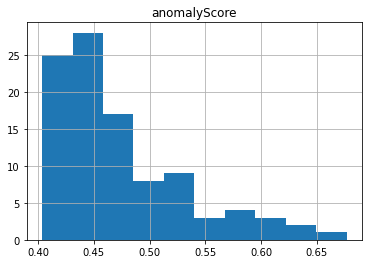

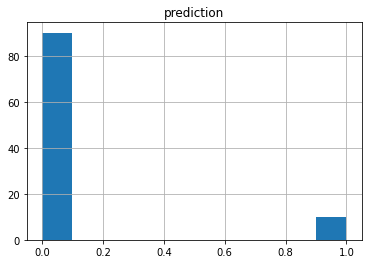

In [330]:
pandas_df=new_df.toPandas()
# print(pandas_df)

pandas_df.hist(column='anomalyScore')
pandas_df.hist(column='prediction')


In [0]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import matplotlib.pyplot as plt
# from matplotlib import pyplot
import plotly.graph_objects as go

plot_data=go.Scatter(name='Usage',showlegend=True,x=date_time_list, y=anomalyScores_list)

fig.show(renderer="colab")

anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=anomaly_date,
                               y=pred_list,
                               mode='markers',
                               marker=dict(color="red",
                                           size=11,
                                           line=dict(
                                               color="red",
                                               width=2)))

fig=go.Figure(data=[plot_data,anomalies_map])

In [0]:
!pip install plotly>=4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

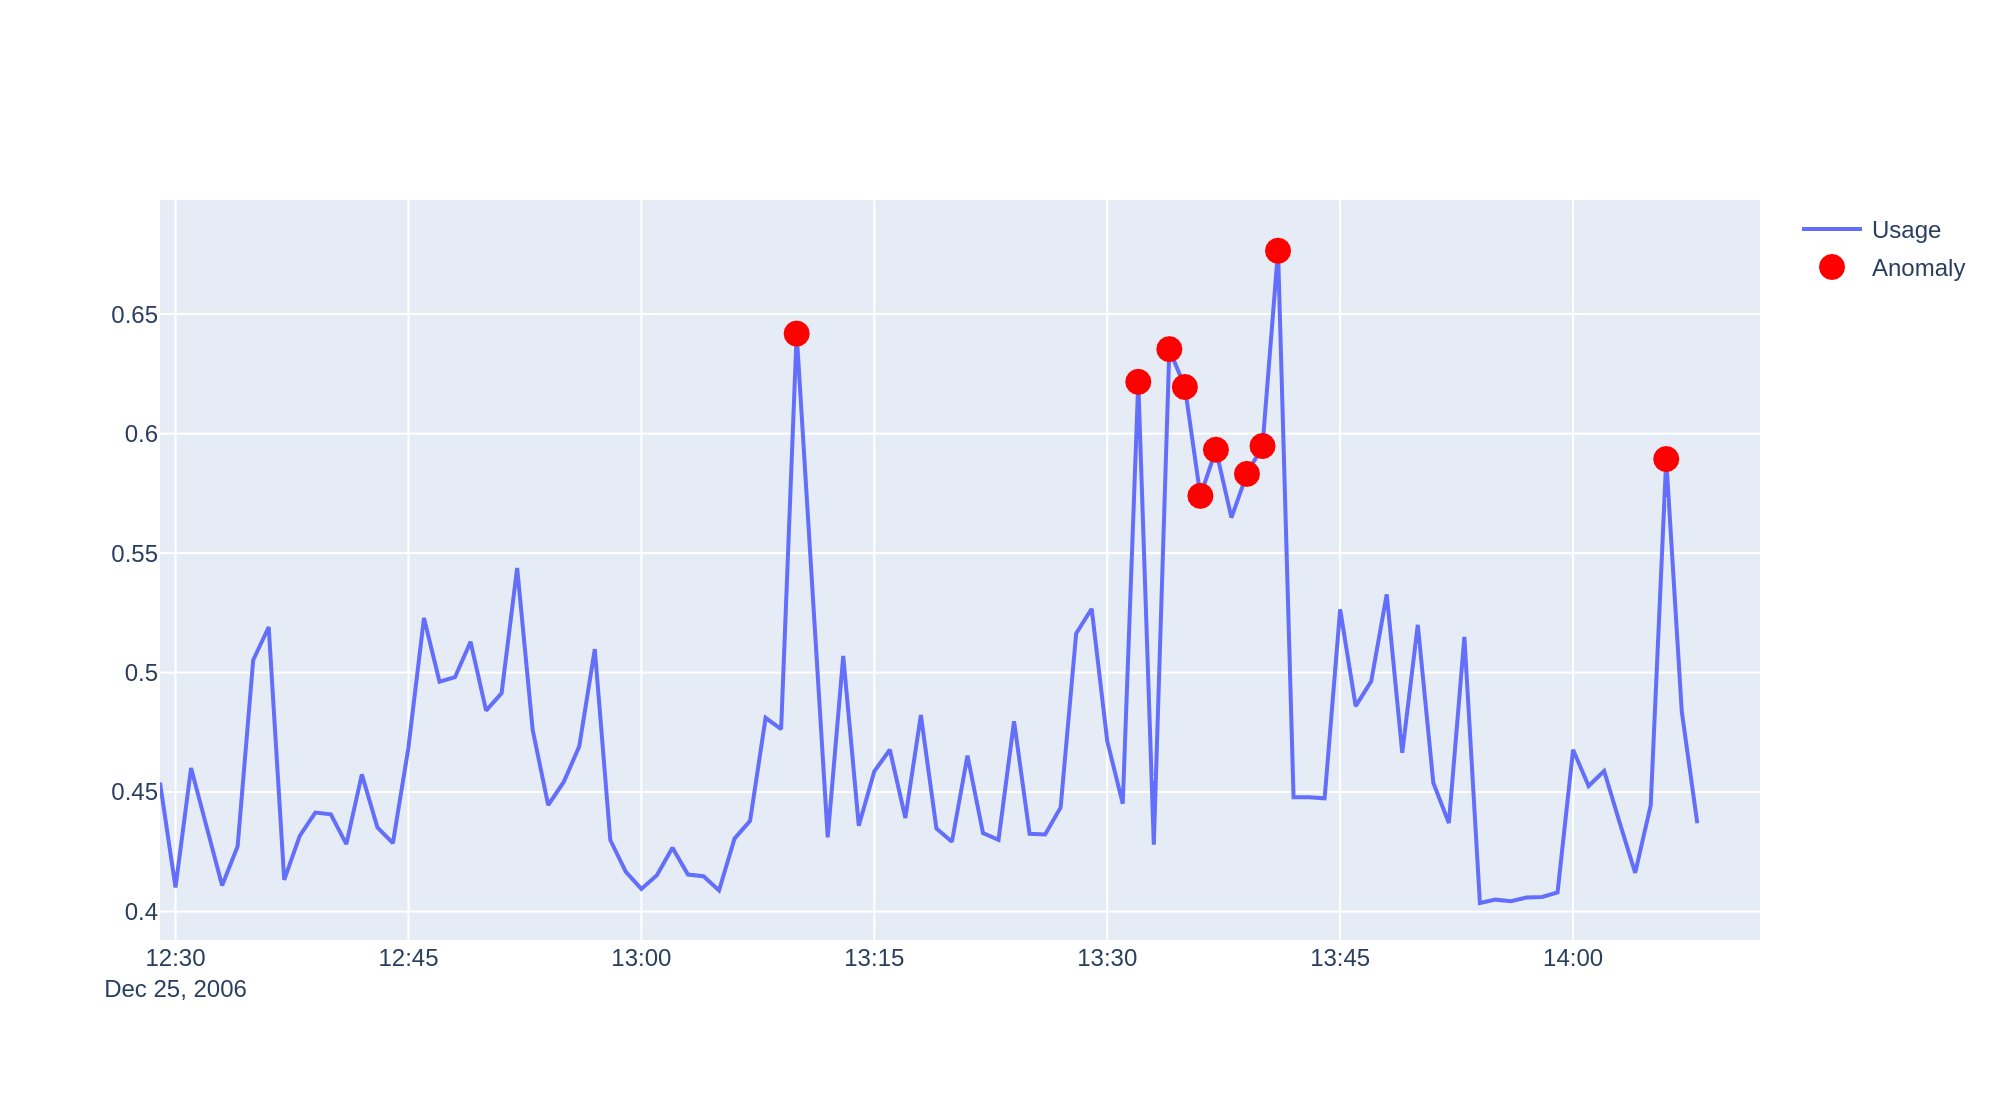

In [328]:
from IPython.display import Image
img_bytes = fig.to_image(format="png", width=1000, height=550, scale=2)
Image(img_bytes)
# fig.write_image("anomaly_Last100.png")